# Performing SGOOP on a model potential

*In this notebook, we'll demonstrate how the `sgoop` Python library can be used to perform spectral gap optimization of order parameters (SGOOP) on a model potential energy surface. *

---

## preparing our environment
First, we import a few libraries that are generally useful for scientific computation and data visualization in Python. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## creating model data

Next we define the first three-well potential function used in the [preprint by Zach Smith et al](https://www.biorxiv.org/content/early/2018/10/10/438549). We call the function `single_sgoop_potential` because we expect a single round of SGOOP will be sufficient to identify a 1-dimensional RC that effectively distinguishes between all 3 wells.

In [5]:
# define model potential
def single_sgoop_potential(x, y):
    return (
        -12 * np.exp(-4.5 * np.square(x + 0.75) - 3 * np.square(y + 0.5))
        - 16 * np.exp(-2 * np.square(x) - 2 * np.square(y - 1))
        - 12 * np.exp(-4.5 * np.square(x - 0.75) - 3 * np.square(y + 0.5))
        + 0.05 * (np.power(x, 6) + np.power(y, 6))
    )

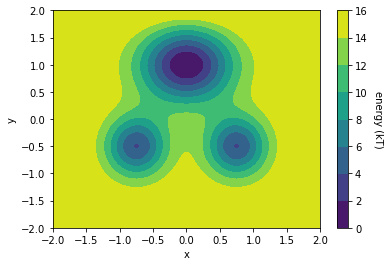

In [9]:
# create range of x and y values, and calculate 2D potential energy surface
xaxis = np.linspace(-2.0, 2.0, 100)
yaxis = np.linspace(-2.0, 2.0, 100)
potential_energy_surface = single_sgoop_potential(
    xaxis[:, None], yaxis[None, :]
) 

# shift and clip high energy values for a prettier visualization
max_val = 16
shifted_pes = potential_energy_surface - potential_energy_surface.min()
shifted_pes[shifted_pes > max_val] = max_val

# plot potential energy surface
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('energy (kT)', rotation=270)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

It is easiest to cast our data in the form of a molecular dynamics (MD) trajectory, since the `sgoop` Python library has been designed with MD users in mind. However, using a static diffusion constant for the MaxCal dynamic observable, there is no need for this trajectory to follow a physically meaningful course. In this case, we will step through each square on our 2D potential energy grid, and assign a weight to each step based on the potential energy value of that square. 

In [4]:
# intialize empty pandas DataFrame to hold mock MD traj
md_traj = pd.DataFrame(
    columns=['x', 'y', 'weights']
)
x_col = []
y_col = []
weight_col = []

# step through potential energy surface, assigning weight (probability)
# to each square.
for idx, energy in np.ndenumerate(potential_energy_surface):
    x = xaxis[idx[0]]
    y = yaxis[idx[1]]
    x_col.append(x)
    y_col.append(y)
    weight_col.append(np.exp(-energy))
md_traj['x'] = x_col
md_traj['y'] = y_col
md_traj['weights'] = weight_col

md_traj.head()

,x,y,weights
0,-2.0,-2.000000,0.001662
1,-2.0,-1.959596,0.002403
2,-2.0,-1.919192,0.003351
3,-2.0,-1.878788,0.004521
4,-2.0,-1.838384,0.005916


Whether we are working with model data or a real MD trajectory, we must create a dictionary of the relevant parameters for calculating the probability and spectral gap along a given reaction coordinate. Please see the `sgoop` documentation for a detailed explanation of the parameters that should be included. This short dictionary of 5 parameters should be sufficient for most operations. In this case, we will be using kernel density estimation with a Gaussian kernel to predict the probability. For larger data sets, density estimation should be performed with histogramming (achieved by setting `kde_bw` to None, or ommitting it from the dictionary).

In [5]:
# specify columns you want to require
sgoop_params = {
    # define parameters for probability estimation
    'rc_bins': 50,
    'kde_bw': 0.01,
    # define parameters for spectral gap calculation
    'd': 4,
    'wells': 3,
    'diffusivity': 1.0
}

All unique linear combinations of x and y (possible reaction coordinates) on a 2D potential energy surface can be represented by an angle between 0 and pi. Because our potential is symmetric about the line x = 0, the unique reaction coordinates can be represented by the angles between 0 and pi/2. Here we use the `sgoop.rc_eval` function to calculate the spectral gap for 20 equally spaced angles in this range. The angle that yields the largest spectral gap should be able to distinguish between the three energy wells. The `angle_to_rc` function is provided as a conveinent way to convert an angle (in radians) to the reaction coordinate `rc = [cos(theta), sin(theta)]`.

In [6]:
from sgoop.sgoop import rc_eval
from sgoop.utilities import angle_to_rc

# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    sg[idx] = rc_eval(
        rc,
        md_traj[['x', 'y']],
        sgoop_params,
        weights=md_traj['weights'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

rc 0:  angle:  0.000  sg:  0.068
rc 1:  angle:  0.083  sg:  0.009
rc 2:  angle:  0.165  sg:  0.010
rc 3:  angle:  0.248  sg:  0.013
rc 4:  angle:  0.331  sg:  0.009
rc 5:  angle:  0.413  sg:  0.001
rc 6:  angle:  0.496  sg:  0.009
rc 7:  angle:  0.579  sg:  0.011
rc 8:  angle:  0.661  sg:  0.011
rc 9:  angle:  0.744  sg:  0.007
rc10:  angle:  0.827  sg:  0.004
rc11:  angle:  0.909  sg:  0.006
rc12:  angle:  0.992  sg:  0.044
rc13:  angle:  1.075  sg:  0.054
rc14:  angle:  1.157  sg:  0.050
rc15:  angle:  1.240  sg:  0.033
rc16:  angle:  1.323  sg:  0.011
rc17:  angle:  1.405  sg:  0.013
rc18:  angle:  1.488  sg:  0.023
rc19:  angle:  1.571  sg:  0.038
optimized RC: [1. 0.]
spectral gap: 0.068425812798252


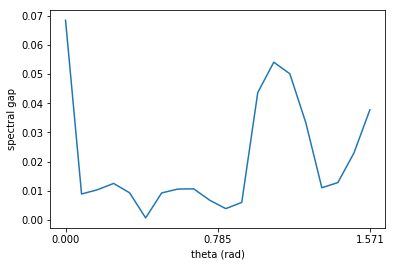

In [7]:
# plot sg vs. theta
plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

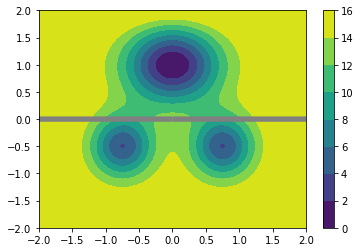

In [8]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

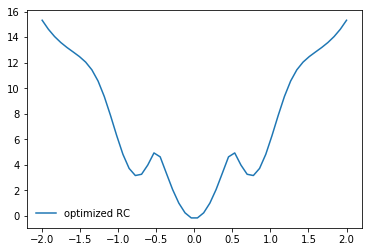

In [7]:
from sgoop.visualization import plot_pmf

plot_pmf(
    opt_rc,
    md_traj[['x', 'y']],
    sgoop_params,
    weights=md_traj['weights'],
)

## try SGOOP on more difficult potential energy surface

In [6]:
def double_sgoop_potential(x, y):
    return (
        -12 * np.exp(-4.5 * np.square(x + 0.55) - 3 * np.square(y + 0.5))
        - 16 * np.exp(-2 * np.square(x) - 2 * np.square(y - 1))
        - 12 * np.exp(-4.5 * np.square(x - 0.55) - 3 * np.square(y + 0.5))
        + 0.05 * (np.power(x, 6) + np.power(y, 6))
    )

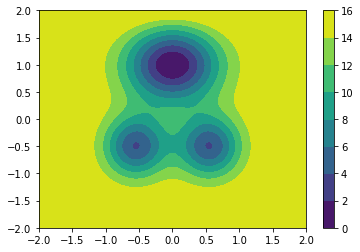

In [24]:
# calculate 2D potential energy surface
xaxis = np.linspace(-2.0, 2.0, 100)
yaxis = np.linspace(-2.0, 2.0, 100)

potential_energy_surface = double_sgoop_potential(
    xaxis[:, None], yaxis[None, :]
) 

# shift and clip high energy values for visualization
max_val = 16
shifted_pes = potential_energy_surface - potential_energy_surface.min()
shifted_pes[shifted_pes > max_val] = max_val

# plot potential energy surface
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')

In [14]:
# intialize empty pandas DataFrame to hold mock MD traj
md_traj = pd.DataFrame(
    columns=['x', 'y', 'weights']
)
x_col = []
y_col = []
weight_col = []

# step through potential energy surface, assigning weight (probability)
# to each square.
for idx, energy in np.ndenumerate(potential_energy_surface):
    x = xaxis[idx[0]]
    y = yaxis[idx[1]]
    x_col.append(x)
    y_col.append(y)
    weight_col.append(np.exp(-energy))
md_traj['x'] = x_col
md_traj['y'] = y_col
md_traj['weights'] = weight_col

md_traj.head()

,x,y,weights
0,-2.0,-2.000000,0.001662
1,-2.0,-1.959596,0.002403
2,-2.0,-1.919192,0.003351
3,-2.0,-1.878788,0.004521
4,-2.0,-1.838384,0.005916


In [15]:
# specify columns you want to require
sgoop_params = {
    # define parameters for probability estimation
    'rc_bins': 50,
    'kde_bw': 0.01,
    # define parameters for spectral gap calculation
    'd': 4,
    'wells': 3,
    'diffusivity': 1.0
}

In [16]:
from sgoop.sgoop import rc_eval
from sgoop.utilities import angle_to_rc

# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    sg[idx] = rc_eval(
        rc,
        md_traj[['x', 'y']],
        sgoop_params,
        weights=md_traj['weights'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

rc 0:  angle:  0.000  sg:  0.042
rc 1:  angle:  0.083  sg:  0.005
rc 2:  angle:  0.165  sg:  0.008
rc 3:  angle:  0.248  sg:  0.006
rc 4:  angle:  0.331  sg:  0.000
rc 5:  angle:  0.413  sg:  0.007
rc 6:  angle:  0.496  sg:  0.013
rc 7:  angle:  0.579  sg:  0.012
rc 8:  angle:  0.661  sg:  0.012
rc 9:  angle:  0.744  sg:  0.013
rc10:  angle:  0.827  sg:  0.005
rc11:  angle:  0.909  sg:  0.016
rc12:  angle:  0.992  sg:  0.023
rc13:  angle:  1.075  sg:  0.018
rc14:  angle:  1.157  sg:  0.007
rc15:  angle:  1.240  sg:  0.007
rc16:  angle:  1.323  sg:  0.013
rc17:  angle:  1.405  sg:  0.017
rc18:  angle:  1.488  sg:  0.028
rc19:  angle:  1.571  sg:  0.037
optimized RC: [1. 0.]
spectral gap: 0.04239133934515871


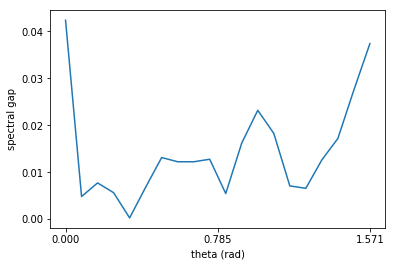

In [17]:
# plot sg vs. theta
plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

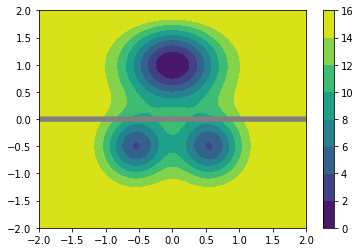

In [18]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

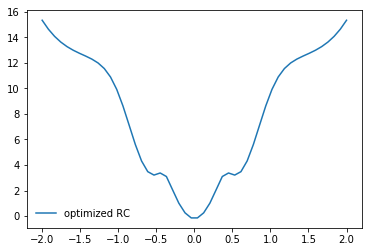

In [19]:
from sgoop.sgoop import md_prob

############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    md_traj[['x', 'y']],
    md_traj['weights'],
    sgoop_params.get('rc_bins'),
    sgoop_params.get('kde_bw'),
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()

In [20]:
# Fails self consistency

In [21]:
# specify columns you want to require
sgoop_params = {
    # define parameters for probability estimation
    'rc_bins': 50,
    'kde_bw': 0.01,
    # define parameters for spectral gap calculation
    'd': 4,
    'wells': 2,
    'diffusivity': 1.0
}

In [22]:
from sgoop.sgoop import rc_eval
from sgoop.utilities import angle_to_rc

# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    sg[idx] = rc_eval(
        rc,
        md_traj[['x', 'y']],
        sgoop_params,
        weights=md_traj['weights'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

rc 0:  angle:  0.000  sg:  0.000
rc 1:  angle:  0.083  sg:  0.001
rc 2:  angle:  0.165  sg:  0.020
rc 3:  angle:  0.248  sg:  0.040
rc 4:  angle:  0.331  sg:  0.058
rc 5:  angle:  0.413  sg:  0.068
rc 6:  angle:  0.496  sg:  0.073
rc 7:  angle:  0.579  sg:  0.075
rc 8:  angle:  0.661  sg:  0.075
rc 9:  angle:  0.744  sg:  0.074
rc10:  angle:  0.827  sg:  0.074
rc11:  angle:  0.909  sg:  0.060
rc12:  angle:  0.992  sg:  0.056
rc13:  angle:  1.075  sg:  0.063
rc14:  angle:  1.157  sg:  0.074
rc15:  angle:  1.240  sg:  0.078
rc16:  angle:  1.323  sg:  0.073
rc17:  angle:  1.405  sg:  0.066
rc18:  angle:  1.488  sg:  0.056
rc19:  angle:  1.571  sg:  0.038
optimized RC: [0.32469947 0.94581724]
spectral gap: 0.07820450851365446


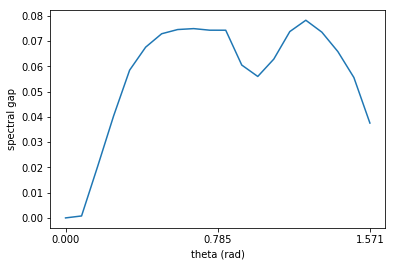

In [23]:
# plot sg vs. theta
plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

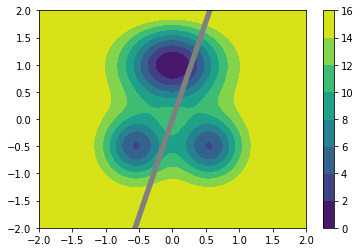

In [24]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

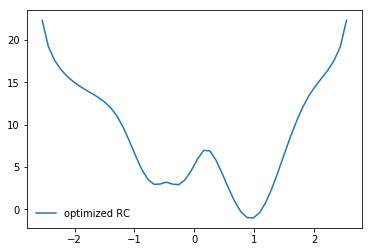

In [26]:
from sgoop.sgoop import md_prob

############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    md_traj[['x', 'y']],
    md_traj['weights'],
    sgoop_params.get('rc_bins'),
    sgoop_params.get('kde_bw'),
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()